Central data point in train set: ('1.1000', '2.7500')
Mean error on alphaD 0.004137095385306499


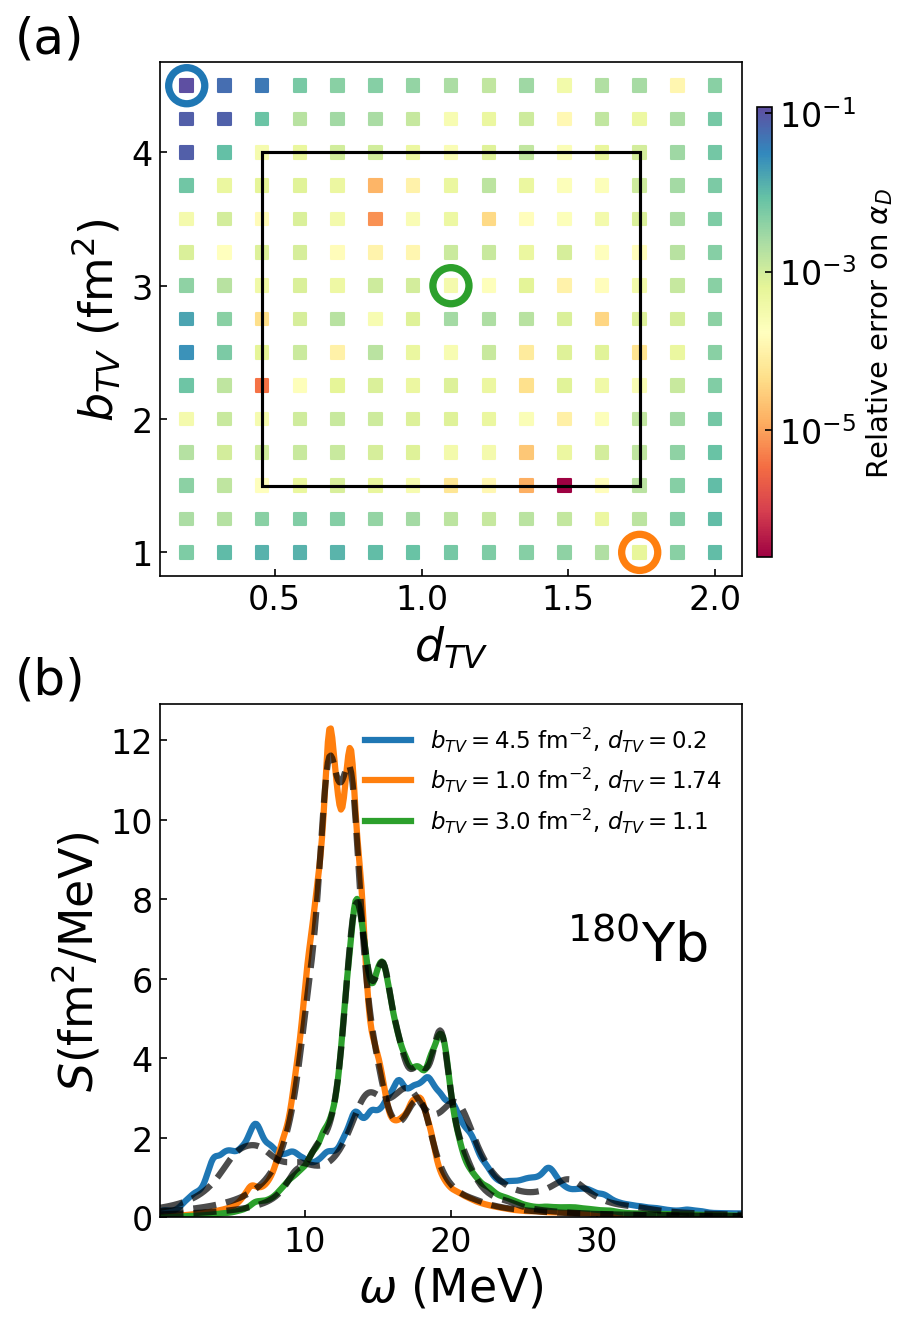

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 31 16:02:03 2025

@author: anteravlic
"""


import numpy as np
from pathlib import Path
import sys
sys.path.insert(0, str(Path("..").resolve()))
from dipoles_exp_param import helper as helper
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import os
import re
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from numpy.polynomial.polynomial import Polynomial
import scipy.interpolate as interpolate


# Set global font size
plt.rcParams.update({'font.size': 16})
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


fig, ax = plt.subplots(2,1 , dpi = 150, figsize = (5,10))

n = 16
retain = 0.6

#params = np.loadtxt('../dipoles_exp_param/params_'+str(n)+'_'+str(retain)+'.txt')
params = np.loadtxt(f'../dipoles_exp_param/runs_Em1/n{n}_r{retain}/params_best.txt')
params = params.astype(np.float32)

test_set = []
with open("../dipoles_exp_param/train_set.txt", "r") as f:
    for line in f:
        tup = tuple(map(str, line.strip().split(",")))  # Convert back to tuple of integers
        test_set.append(tup)

        
        
'''
Calculate central point on train set
'''
# Compute centroid
combined_ar = np.array(test_set, dtype = float)
centroid = combined_ar.mean(axis=0)

# Compute distances from each point to centroid
distances = np.linalg.norm(combined_ar - centroid, axis=1)

# Find index of closest point
central_index = np.argmin(distances)
central_point = tuple(test_set[central_index])
print('Central data point in train set:', central_point)

strength = []
alphaD = []
fmt_data = []

formatted_alpha_values = []
formatted_beta_values = []

strength_dir = '../dipoles_data_all/total_strength/'
alphaD_dir = '../dipoles_data_all/total_alphaD/'

# Pattern for strength files: strength_beta_alpha.out
pattern = re.compile(r'strength_([0-9.]+)_([0-9.]+)\.out')

for fname in os.listdir(strength_dir):
    match = pattern.match(fname)
    if match:
        beta = match.group(1)
        alpha = match.group(2)
        #if ((alpha, beta)) in test_set:
        #if ((alpha, beta)) not in test_set and ((alpha, beta)) not in cv_set:
            #if ((float(beta_val) <= 4.0 and float(beta_val) >= 1.5) and (float(alpha_val) <= 1.8 and float(alpha_val) >= 0.4)):
        #if (float(alpha) > 0.5) :
        strength_file = os.path.join(strength_dir, fname)
        alphaD_file = os.path.join(alphaD_dir, f'alphaD_{beta}_{alpha}.out')

        if os.path.exists(alphaD_file):
            # Read data
            file_strength = np.loadtxt(strength_file)
            file_alphaD = np.loadtxt(alphaD_file)


            # Store
            strength.append(file_strength)
            alphaD.append(file_alphaD)
            fmt_data.append((alpha, beta))
            
            formatted_alpha_values.append(alpha)
            formatted_beta_values.append(beta)



# Example lists
alpha = formatted_alpha_values
beta = formatted_beta_values

# Combine the lists into pairs
#combined = [(x, y) for x in alpha for y in beta]
combined = []
for i in range(len(alpha)):
    combined.append((alpha[i], beta[i]))




alphaD_opt = []
opt_strength = []
orig_strength = []
opt_Bs = []
opt_eigs = []


for idx in range(len(combined)):
    
    alpha_tensor = tf.constant(float(combined[idx][0]), dtype=tf.float32)  # (batch,)
    beta_tensor  = tf.constant(float(combined[idx][1]), dtype=tf.float32)

    
    
    
    opt_D, opt_S1, opt_S2,opt_S3,opt_S4, opt_v0,opt_v1, opt_v2, fold, x1, x2, x3, x4 = helper.modified_DS_affine_v(params, n)
    #opt_eigenvalues, opt_eigenvectors = helper.generalized_eigen(opt_D.numpy(), opt_S1.numpy(), opt_S2.numpy(), combined[idx], central_point)
    exp1 = tf.exp( -(alpha_tensor- float(central_point[0])) * x1)

    
    M_true = opt_D + (alpha_tensor- float(central_point[0])) * opt_S1 \
                + (beta_tensor- float(central_point[1])) * opt_S2 \
                + (beta_tensor- float(central_point[1])) * exp1 * opt_S3  \
                #+ beta_tensor * exp2 * opt_S4
                
    opt_eigenvalues, opt_eigenvectors = tf.linalg.eigh(M_true)
    
    n_i = opt_eigenvalues.shape[0]
    k_keep = int(round(retain * n_i))         # how many eigenvalues to keep
    k_keep = max(1, min(k_keep, n_i))         # safety: clamp between 1 and n
    
    left  = (n_i - k_keep) // 2               # starting index of the centered block
    right = left + k_keep                     # ending index (exclusive)
    
    opt_eigenvalues  = opt_eigenvalues[left:right]
    opt_eigenvectors = opt_eigenvectors[:, left:right]


    
    v_eff = opt_v0 \
         + (alpha_tensor- float(central_point[0])) * opt_v1 \
         + (beta_tensor- float(central_point[1])) * opt_v2 
            
    projections = tf.linalg.matvec(tf.transpose(opt_eigenvectors), v_eff)
    
    # Square each projection
    B = tf.square(projections)
    
    mask = tf.cast((opt_eigenvalues > 1), dtype=tf.float32)
    
    # Apply the mask to zero out B where eigenvalue is negative
    opt_dot_products = B * mask
    
    
    
    
    
    
    x = strength[idx][:,0]
    x = x.astype(np.float32)
    orig = strength[idx]
    orig_strength.append(orig)
    
    eta_new = tf.sqrt(fold**2 + (x2 + x3*(alpha_tensor- float(central_point[0])) + x4*(beta_tensor- float(central_point[1])))**2)
        
    opt_Lor = helper.give_me_Lorentzian(x, opt_eigenvalues, opt_dot_products, eta_new)
    
    opt_Bs.append(opt_dot_products)
    opt_eigs.append(opt_eigenvalues)
    
    opt_strength.append(opt_Lor)
    
    alphaD_opt.append(helper.calculate_alphaD(opt_eigenvalues, B))
    
    #plt.plot(x, opt_Lor, ls = '--')
    #print(combined[idx])
    #plt.plot(x, orig, ls = '-')

alphaD_opt = np.array(alphaD_opt)







# plot the points
'''
Discrepancy on plot with points
'''
alphaD = np.vstack(alphaD)
x = [float(i) for i,j in combined]
y = [float(j) for i,j in combined]
c = np.abs(alphaD_opt - alphaD[:,2])/alphaD[:,2]
print('Mean error on alphaD', np.mean(c))
# L2 (Euclidean) norm of the difference for each pair
#l2_norms = [np.linalg.norm(a - b)/np.linalg.norm(b)  for a, b in zip(opt_strength, orig_strength)]
im = ax[0].scatter(x, y, c = c, marker='s', cmap = 'Spectral', norm = LogNorm())
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # adjust these numbers as needed
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"Relative error on $\alpha_D$", fontsize=14)
# --- Relative L2 error on the strength function (top panel) ---
# We keep coordinates of the scatter the same:
# x_vals = [float(i) for i, j in combined]   # d_TV
# y_vals = [float(j) for i, j in combined]   # b_TV

# rel_L2 = np.empty(len(combined), dtype=float)

# for k, (S_hat_k, true_pair_k) in enumerate(zip(opt_strength, orig_strength)):
#     E = np.asarray(true_pair_k[:, 0], dtype=np.float64)   # energy grid
#     S_true = np.asarray(true_pair_k[:, 1], dtype=np.float64)
#     S_hat  = np.asarray(S_hat_k, dtype=np.float64)        # emulator on same grid

#     # Relative L2: ∫(Ŝ−S)^2 dE / ∫S^2 dE
#     num = np.trapz((S_hat - S_true)**2, E)
#     den = np.trapz((S_true)**2, E)
#     rel_L2[k] = num / den if den > 0 else np.nan

# # Handle zeros/NaNs for LogNorm (avoid log(0))
# mask = np.isfinite(rel_L2)
# c_vals = np.clip(rel_L2[mask], 1e-16, None)
# x_plot = np.asarray(x_vals)[mask]
# y_plot = np.asarray(y_vals)[mask]

# im = ax[0].scatter(x_plot, y_plot, c=c_vals, marker='s', cmap='Spectral', norm=LogNorm())
# cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"Relative error on strength", fontsize=14)

# (the training-rectangle code that follows can stay exactly as-is)



# Convert train_set to float arrays for min/max
train_alpha = [float(a) for (a, b) in test_set]
train_beta  = [float(b) for (a, b) in test_set]

alpha_min = min(train_alpha)
alpha_max = max(train_alpha)
beta_min  = min(train_beta)
beta_max  = max(train_beta)

# Add rectangle to ax_grid
train_rect = patches.Rectangle(
    (alpha_min, beta_min),
    alpha_max - alpha_min,
    beta_max - beta_min,
    linewidth=1.5,
    edgecolor='black',
    facecolor='none'
)
ax[0].add_patch(train_rect)
ax[0].set_xlabel('$d_{TV}$', size = 22)
ax[0].set_ylabel('$b_{TV}$ (fm${}^{2}$)', size = 22)


# '''
# This here plots the Lorentzians
# '''
idx =  [46, 18, 62]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(idx)):
    
    alpha = float(combined[idx[i]][0])
    beta = float(combined[idx[i]][1])
    
    ax[0].scatter(alpha, beta, ec = colors[i], s = 300, fc = 'none',linewidths=3.5)
    
    x = orig_strength[idx[i]][:,0]
    
    ax[1].plot(x, opt_strength[idx[i]], color = 'black', ls = '--', lw = 3, alpha = 0.7, zorder=99)
    ax[1].plot(x, orig_strength[idx[i]][:,1], lw = 3, label = '$b_{TV}= $'+str(round(beta,2))+' fm${}^{-2}$, $d_{TV} = $'+str(round(alpha,2)),
               color = colors[i])
    
ax[1].set_ylim(0)
ax[1].set_xlim(np.min(x), np.max(x))
ax[1].legend(frameon = False, fontsize = 11)


ax[1].set_xlabel(r'$\omega$ (MeV)', size = 22)
ax[1].set_ylabel('$S$(fm${}^{2}$/MeV)', size = 22)

ax[0].annotate('(a)', (-0.25, 1.02), xycoords='axes fraction', size = 24)
ax[1].annotate('(b)', (-0.25, 1.02), xycoords='axes fraction', size = 24)
ax[1].annotate('${}^{180}$Yb', (0.7, 0.5), xycoords='axes fraction', size = 26)

plt.subplots_adjust(hspace = 0.25)

#plt.savefig('YbPerformance.pdf', bbox_inches='tight')






Central data point in train set: ('1.1000', '2.7500')
Mean relative error on α_D (TEST set): 4.386138e-03
Mean error on alphaD (ALL points): 0.0023058887481093543


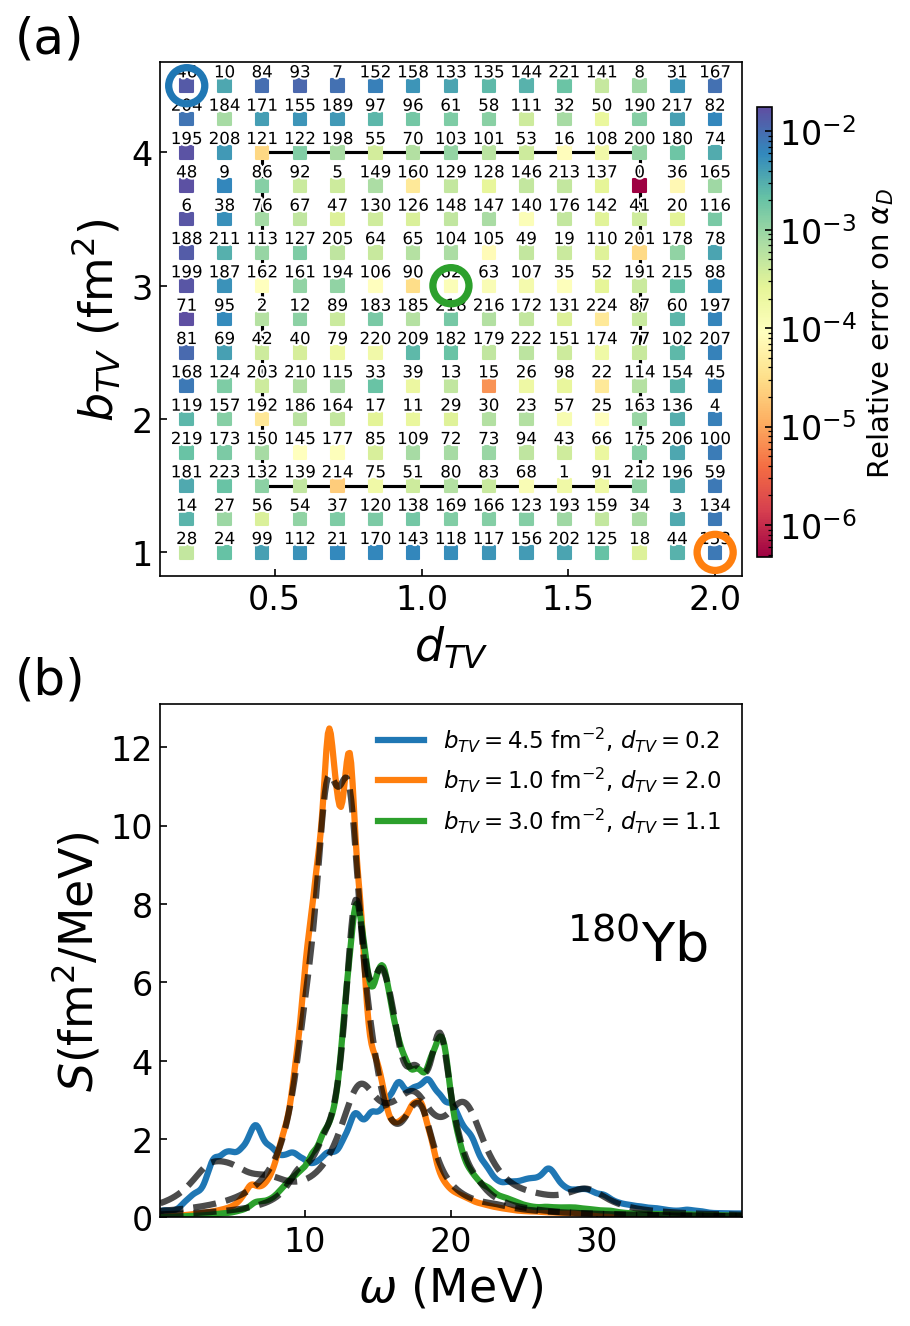

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 31 16:02:03 2025
"""

import numpy as np
from pathlib import Path
import sys
sys.path.insert(0, str(Path("..").resolve()))
from dipoles_exp_param import helper as helper
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import os
import re
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from numpy.polynomial.polynomial import Polynomial
import scipy.interpolate as interpolate
import matplotlib.patheffects as pe  # <-- for outlined text

# Set global font size
plt.rcParams.update({'font.size': 16})
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

fig, ax = plt.subplots(2,1 , dpi = 150, figsize = (5,10))

n = 15
retain = 0.6

# Load EM1 params
params = np.loadtxt(f'../dipoles_exp_param/runs_Em1/n{n}_r{retain}/params_best.txt').astype(np.float32)

# --------------------------- load TRAIN SET ---------------------------
train_set = []
with open("../dipoles_exp_param/train_set.txt", "r") as f:
    for line in f:
        tup = tuple(map(str, line.strip().split(",")))
        if len(tup) == 2:
            train_set.append(tup)
train_set_set = set(train_set)
# ---------------------------------------------------------------------

# ---- central point from TRAIN set (as you had it) ----
combined_ar = np.array(train_set, dtype=float)
centroid = combined_ar.mean(axis=0)
distances = np.linalg.norm(combined_ar - centroid, axis=1)
central_index = np.argmin(distances)
central_point = tuple(train_set[central_index])
print('Central data point in train set:', central_point)

strength = []
alphaD = []
fmt_data = []

formatted_alpha_values = []
formatted_beta_values = []

strength_dir = '../dipoles_data_all/total_strength/'
alphaD_dir = '../dipoles_data_all/total_alphaD/'

# Pattern for strength files: strength_beta_alpha.out
pattern = re.compile(r'strength_([0-9.]+)_([0-9.]+)\.out')

for fname in os.listdir(strength_dir):
    match = pattern.match(fname)
    if match:
        beta = match.group(1)
        alpha = match.group(2)
        strength_file = os.path.join(strength_dir, fname)
        alphaD_file = os.path.join(alphaD_dir, f'alphaD_{beta}_{alpha}.out')

        if os.path.exists(alphaD_file):
            file_strength = np.loadtxt(strength_file)
            file_alphaD = np.loadtxt(alphaD_file)
            strength.append(file_strength)
            alphaD.append(file_alphaD)
            fmt_data.append((alpha, beta))
            formatted_alpha_values.append(alpha)
            formatted_beta_values.append(beta)

# All available (alpha,beta) pairs in the SAME order as strength/alphaD we just loaded
combined = [(formatted_alpha_values[i], formatted_beta_values[i]) for i in range(len(formatted_alpha_values))]

alphaD_opt = []
opt_strength = []
orig_strength = []
opt_Bs = []
opt_eigs = []

for idx in range(len(combined)):
    alpha_tensor = tf.constant(float(combined[idx][0]), dtype=tf.float32)
    beta_tensor  = tf.constant(float(combined[idx][1]), dtype=tf.float32)

    opt_D, opt_S1, opt_S2, opt_S3, opt_S4, opt_v0, opt_v1, opt_v2, fold, x1, x2, x3, x4 = helper.modified_DS_affine_v(params, n)
    exp1 = tf.exp(-(alpha_tensor - float(central_point[0])) * x1)

    M_true = (opt_D
              + (alpha_tensor - float(central_point[0])) * opt_S1
              + (beta_tensor  - float(central_point[1])) * opt_S2
              + (beta_tensor  - float(central_point[1])) * exp1 * opt_S3)

    opt_eigenvalues, opt_eigenvectors = tf.linalg.eigh(M_true)

    n_i = opt_eigenvalues.shape[0]
    k_keep = int(round(retain * n_i))
    k_keep = max(1, min(k_keep, n_i))
    left  = (n_i - k_keep) // 2
    right = left + k_keep
    opt_eigenvalues  = opt_eigenvalues[left:right]
    opt_eigenvectors = opt_eigenvectors[:, left:right]

    v_eff = (opt_v0
             + (alpha_tensor - float(central_point[0])) * opt_v1
             + (beta_tensor  - float(central_point[1])) * opt_v2)

    projections = tf.linalg.matvec(tf.transpose(opt_eigenvectors), v_eff)
    B = tf.square(projections)

    mask = tf.cast((opt_eigenvalues > 1), dtype=tf.float32)
    opt_dot_products = B * mask

    x = strength[idx][:,0].astype(np.float32)
    orig = strength[idx]
    orig_strength.append(orig)

    eta_new = tf.sqrt(fold**2 + (x2 + x3*(alpha_tensor - float(central_point[0])) + x4*(beta_tensor - float(central_point[1])))**2)
    opt_Lor = helper.give_me_Lorentzian(x, opt_eigenvalues, opt_dot_products, eta_new)

    opt_Bs.append(opt_dot_products)
    opt_eigs.append(opt_eigenvalues)
    opt_strength.append(opt_Lor)

    alphaD_opt.append(helper.calculate_alphaD(opt_eigenvalues, B))

alphaD_opt = np.array(alphaD_opt)
alphaD = np.vstack(alphaD)

# --------------------- TEST-SET MEAN RELATIVE ERROR ---------------------
is_train = np.array([tuple(p) in train_set_set for p in combined])
is_test  = ~is_train

rel_err_all = np.abs(alphaD_opt - alphaD[:, 2]) / alphaD[:, 2]
mean_rel_err_test = float(np.mean(rel_err_all[is_test])) if np.any(is_test) else float('nan')
print(f"Mean relative error on α_D (TEST set): {mean_rel_err_test:.6e}")
print('Mean error on alphaD (ALL points):', float(np.mean(rel_err_all)))
# -----------------------------------------------------------------------

# -------------------- Scatter + index labels --------------------
x = np.array([float(i) for i, j in combined])
y = np.array([float(j) for i, j in combined])
c = rel_err_all

im = ax[0].scatter(x, y, c=c, marker='s', cmap='Spectral', norm=LogNorm(), zorder=2)

# annotate each point with its index in `combined`
for i, (xi, yi) in enumerate(zip(x, y)):
    ax[0].annotate(
        str(i),
        (xi, yi),
        textcoords="offset points",
        xytext=(0, 4),  # a few points above the marker
        ha="center",
        fontsize=8,
        zorder=3,
        path_effects=[pe.withStroke(linewidth=2.0, foreground="white")]  # white outline for readability
    )

# colorbar
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"Relative error on $\alpha_D$", fontsize=14)
# ---------------------------------------------------------------

# Draw rectangle around TRAIN domain
train_alpha = [float(a) for (a, b) in train_set]
train_beta  = [float(b) for (a, b) in train_set]
alpha_min, alpha_max = min(train_alpha), max(train_alpha)
beta_min,  beta_max  = min(train_beta),  max(train_beta)

train_rect = patches.Rectangle((alpha_min, beta_min),
                               alpha_max - alpha_min,
                               beta_max - beta_min,
                               linewidth=1.5, edgecolor='black', facecolor='none', zorder=1)
ax[0].add_patch(train_rect)
ax[0].set_xlabel('$d_{TV}$', size=22)
ax[0].set_ylabel('$b_{TV}$ (fm${}^{2}$)', size=22)

# Lorentzian examples (unchanged)
idx = [46, 153, 62]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(idx)):
    alpha_v = float(combined[idx[i]][0])
    beta_v  = float(combined[idx[i]][1])
    ax[0].scatter(alpha_v, beta_v, ec=colors[i], s=300, fc='none', linewidths=3.5, zorder=4)

    xE = orig_strength[idx[i]][:,0]
    ax[1].plot(xE, opt_strength[idx[i]], color='black', ls='--', lw=3, alpha=0.7, zorder=99)
    ax[1].plot(xE, orig_strength[idx[i]][:,1], lw=3,
               label = '$b_{TV}= $'+str(round(beta_v,2))+' fm${}^{-2}$, $d_{TV} = $'+str(round(alpha_v,2)),
               color = colors[i])

ax[1].set_ylim(0)
ax[1].set_xlim(np.min(xE), np.max(xE))
ax[1].legend(frameon=False, fontsize=11)

ax[1].set_xlabel(r'$\omega$ (MeV)', size=22)
ax[1].set_ylabel('$S$(fm${}^{2}$/MeV)', size=22)

ax[0].annotate('(a)', (-0.25, 1.02), xycoords='axes fraction', size=24)
ax[1].annotate('(b)', (-0.25, 1.02), xycoords='axes fraction', size=24)
ax[1].annotate('${}^{180}$Yb', (0.7, 0.5), xycoords='axes fraction', size=26)

plt.subplots_adjust(hspace=0.25)
# plt.savefig('YbPerformance.pdf', bbox_inches='tight')
plt.show()
